# Figure 2b (no color)

In [15]:
from matplotlib import pyplot
%matplotlib inline
#import pyproj
import numpy
import geopandas

In [2]:
from django.db import connection

In [6]:
from database.models import Site
from landscape.models import LandCover
from django.contrib.gis.db.models.functions import Intersection, Envelope
from django.contrib.gis.db.models import Collect

In [7]:
from shapely.geometry import shape
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

In [8]:
site = Site.objects.get(name="Hofgarten")

In [10]:
def get_geodataframe(queryset, modification=None, crs={'init':'epsg:4326'}):
    query = queryset.query.sql_with_params()
    if modification:
        query = (modification, query[1])
    return geopandas.read_postgis(query[0], connection, 
                                   geom_col='geometry', 
                                   params=query[1], 
                                   index_col='id',
                                   crs=crs)

In [11]:
def get_landcover(point, radius=100):
    buffer = point.buffer(radius)
    result = LandCover.objects.filter(geometry__intersects=buffer.envelope)\
                          .annotate(intersection=Intersection('geometry', buffer.envelope))#.aggregate(total=Collect('intersection'))
    return result

In [12]:
def get_patch_collection(shapes, edgecolor='black', facecolor='none', hatch=None):
    patches = []
    for shape in shapes:
        try:
            patches.append(PolygonPatch(shape))
        except AssertionError:
            for sub_shape in shape:
                patches.append(PolygonPatch(sub_shape))
    return PatchCollection(patches, edgecolor=edgecolor, facecolor=facecolor, hatch=hatch)

In [13]:
modification = 'SELECT "landscape_landcover"."id", "landscape_landcover"."cover_type", ST_Intersection("landscape_landcover"."geometry", %s) AS "geometry" FROM "landscape_landcover" WHERE ST_Intersects("landscape_landcover"."geometry", %s)'
point_landcover = get_geodataframe(get_landcover(site.geometry, radius = 600),
                                   modification=modification)

In [18]:
radii = geopandas.GeoDataFrame([#{'name': 'recording location', 'geometry': shape(eval(site.geometry.geojson))},
                                {'name': '50m', 'geometry': shape(eval(site.geometry.buffer(50).geojson))},
                                {'name': '100m', 'geometry': shape(eval(site.geometry.buffer(100).geojson))},
                                {'name': '200m', 'geometry': shape(eval(site.geometry.buffer(200).geojson))},
                                {'name': '500m', 'geometry': shape(eval(site.geometry.buffer(500).geojson))},], 
                               index=numpy.arange(4), crs={'init':'epsg:4326'}, geometry='geometry')

In [19]:
buildings = get_patch_collection(shapes=point_landcover[point_landcover.cover_type == 1].geometry.as_matrix(), 
                                 facecolor='0.3', edgecolor='0.7', hatch='///')
surfaces = get_patch_collection(shapes=point_landcover[point_landcover.cover_type == 2].geometry.as_matrix(), 
                                facecolor='0.3')
field = get_patch_collection(shapes=point_landcover[point_landcover.cover_type == 12].geometry.as_matrix(), 
                             facecolor='0.8', hatch='...')
trees = get_patch_collection(shapes=point_landcover[point_landcover.cover_type == 9].geometry.as_matrix(), 
                             facecolor='white')
water = get_patch_collection(shapes=point_landcover[point_landcover.cover_type == 6].geometry.as_matrix(), 
                             hatch='xx')

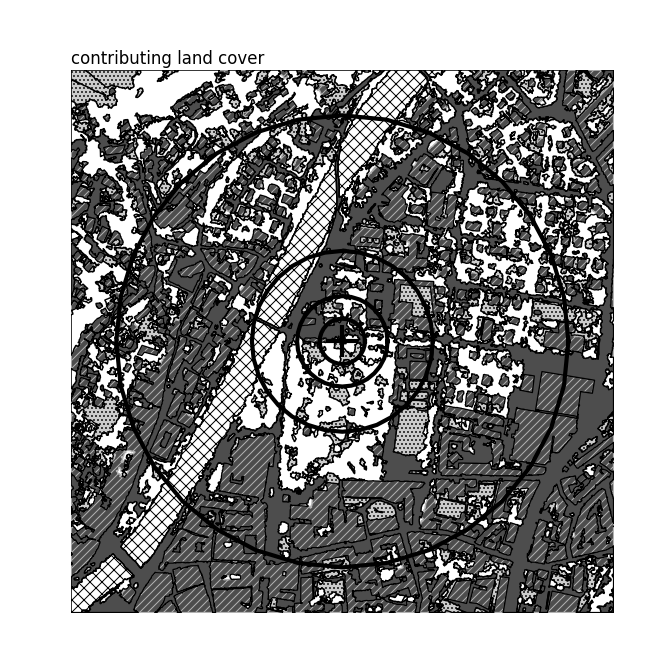

In [20]:
figure3, ax = pyplot.subplots()
figure3.set_dpi(192)
figure3.set_figwidth(7)
figure3.set_figheight(7)
ax.set_aspect('equal')
#p1 = point_landcover.plot(ax=ax, vmax=15, column='cover_type', edgecolor='black')
ax.add_collection(buildings)
ax.add_collection(surfaces)
ax.add_collection(field)
ax.add_collection(trees)
ax.add_collection(water)
p2 = radii.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3, linestyle='-')
#a_hillshade = ax.imshow('data', extent='extent', interpolation='none', data=hillshade, cmap='gray', alpha=0.5)
p3 = ax.scatter(site.geometry.coords[0], site.geometry.coords[1], marker='+', color='black', s=500, linewidths=3)
bbox = numpy.array(site.geometry.buffer(600).envelope.coords[0])
ax.set_xlim([bbox[:, 0].min(), bbox[:, 0].max()])
ax.set_ylim([bbox[:, 1].min(), bbox[:, 1].max()])
ax.set_frame_on(False)
ax.tick_params(axis='both', 
               bottom=False, right=False, top=False, left=False,
               labelbottom=False, labelleft=False)
t2 = ax.set_title('contributing land cover', loc='left')
x = site.geometry.coords[0]
y = site.geometry.coords[1]
#a1 = ax.annotate('200m', (x+150, y+150), xytext=(x+200, y+200), ha='center', va='center', size=12, arrowprops=ap)
#a2 = ax.annotate('500m', (x+450, y+450), xytext=(x+400, y+400), ha='center', va='center', size=12, arrowprops=ap)